# LMS Algorithm

Update rule: $\mathbf{w}_{n+1} = \mathbf{w}_n + \mu e_n \mathbf{y}_n$

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import ipywidgets as widgets
from IPython.display import display, Audio
import seaborn as sns

# Set styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Random seed for reproducibility
np.random.seed(42)

## LMS Implementation

LMS replaces the batch MMSE gradient $\nabla J = -2(\mathbf{K}_{xy} - \mathbf{A}\mathbf{K}_{yy})$ with instantaneous samples:

$$\mathbf{w}_{n+1} = \mathbf{w}_n + \mu e_n \mathbf{y}_n$$

where $e_n = x_n - \mathbf{w}_n^T\mathbf{y}_n$. Normalized LMS (NLMS) scales the update by $\|\mathbf{y}_n\|^2$ for improved stability.

In [2]:
class LMSFilter:
    """
    Modern LMS adaptive filter implementation.
    
    Implements the LMS update rule:
    w(n+1) = w(n) + μ * e(n) * x(n)
    
    where e(n) = d(n) - w^T(n) * x(n)
    """
    
    def __init__(self, n_taps, mu=0.01, normalized=True):
        """
        Initialize LMS filter.
        
        Parameters:
        -----------
        n_taps : int
            Number of filter taps (filter length)
        mu : float
            Step size (learning rate)
        normalized : bool
            Whether to use normalized LMS (NLMS)
        """
        self.n_taps = n_taps
        self.mu = mu
        self.normalized = normalized
        self.epsilon = 1e-8  # Small constant to prevent division by zero
        
        # Initialize weights to zero
        self.w = np.zeros(n_taps)
        
        # Storage for analysis
        self.weight_history = []
        self.error_history = []
        self.mse_history = []
        
    def _create_input_matrix(self, x):
        """
        Create input matrix with time-delayed versions of input signal.
        Each row contains [x(n), x(n-1), ..., x(n-M+1)]
        """
        N = len(x)
        X = np.zeros((N, self.n_taps))
        
        for n in range(N):
            for m in range(self.n_taps):
                if n - m >= 0:
                    X[n, m] = x[n - m]
                    
        return X
    
    def adapt(self, x, d, track_convergence=True):
        """
        Adapt filter weights using LMS algorithm.
        
        Parameters:
        -----------
        x : array_like
            Input signal (reference)
        d : array_like  
            Desired signal
        track_convergence : bool
            Whether to track convergence metrics
            
        Returns:
        --------
        y : ndarray
            Filter output
        e : ndarray
            Error signal
        """
        x = np.asarray(x)
        d = np.asarray(d)
        N = len(x)
        
        # Create input matrix
        X = self._create_input_matrix(x)
        
        # Initialize outputs
        y = np.zeros(N)
        e = np.zeros(N)
        
        # Clear history
        if track_convergence:
            self.weight_history = [self.w.copy()]
            self.error_history = []
            self.mse_history = []
        
        # LMS adaptation loop
        for n in range(N):
            # Filter output
            y[n] = np.dot(self.w, X[n, :])
            
            # Error
            e[n] = d[n] - y[n]
            
            # Weight update
            if self.normalized:
                # Normalized LMS (NLMS)
                norm_factor = np.dot(X[n, :], X[n, :]) + self.epsilon
                self.w += (self.mu * e[n] / norm_factor) * X[n, :]
            else:
                # Standard LMS
                self.w += self.mu * e[n] * X[n, :]
            
            # Track convergence
            if track_convergence:
                self.weight_history.append(self.w.copy())
                self.error_history.append(e[n]**2)
                
                # Running MSE estimate
                if n >= 50:  # After initial transient
                    mse = np.mean(np.array(self.error_history[n-50:n+1]))
                    self.mse_history.append(mse)
                else:
                    self.mse_history.append(e[n]**2)
        
        return y, e
    
    def get_convergence_metrics(self):
        """
        Return convergence analysis metrics.
        """
        return {
            'weights': np.array(self.weight_history),
            'mse': np.array(self.mse_history),
            'final_weights': self.w.copy()
        }
    
    def reset(self):
        """Reset filter weights to zero."""
        self.w = np.zeros(self.n_taps)
        self.weight_history = []
        self.error_history = []
        self.mse_history = []

## Noise Cancellation

Classic adaptive filtering: signal $s(n)$ corrupted by interference $v(n)$. LMS uses correlated reference $x(n)$ to estimate and subtract the interference.

The filter adapts to minimize $\mathbb{E}[e^2(n)]$ where $e(n) = d(n) - y(n) = s(n) + v(n) - \hat{v}(n)$. Convergence extracts $s(n)$ in the error signal.

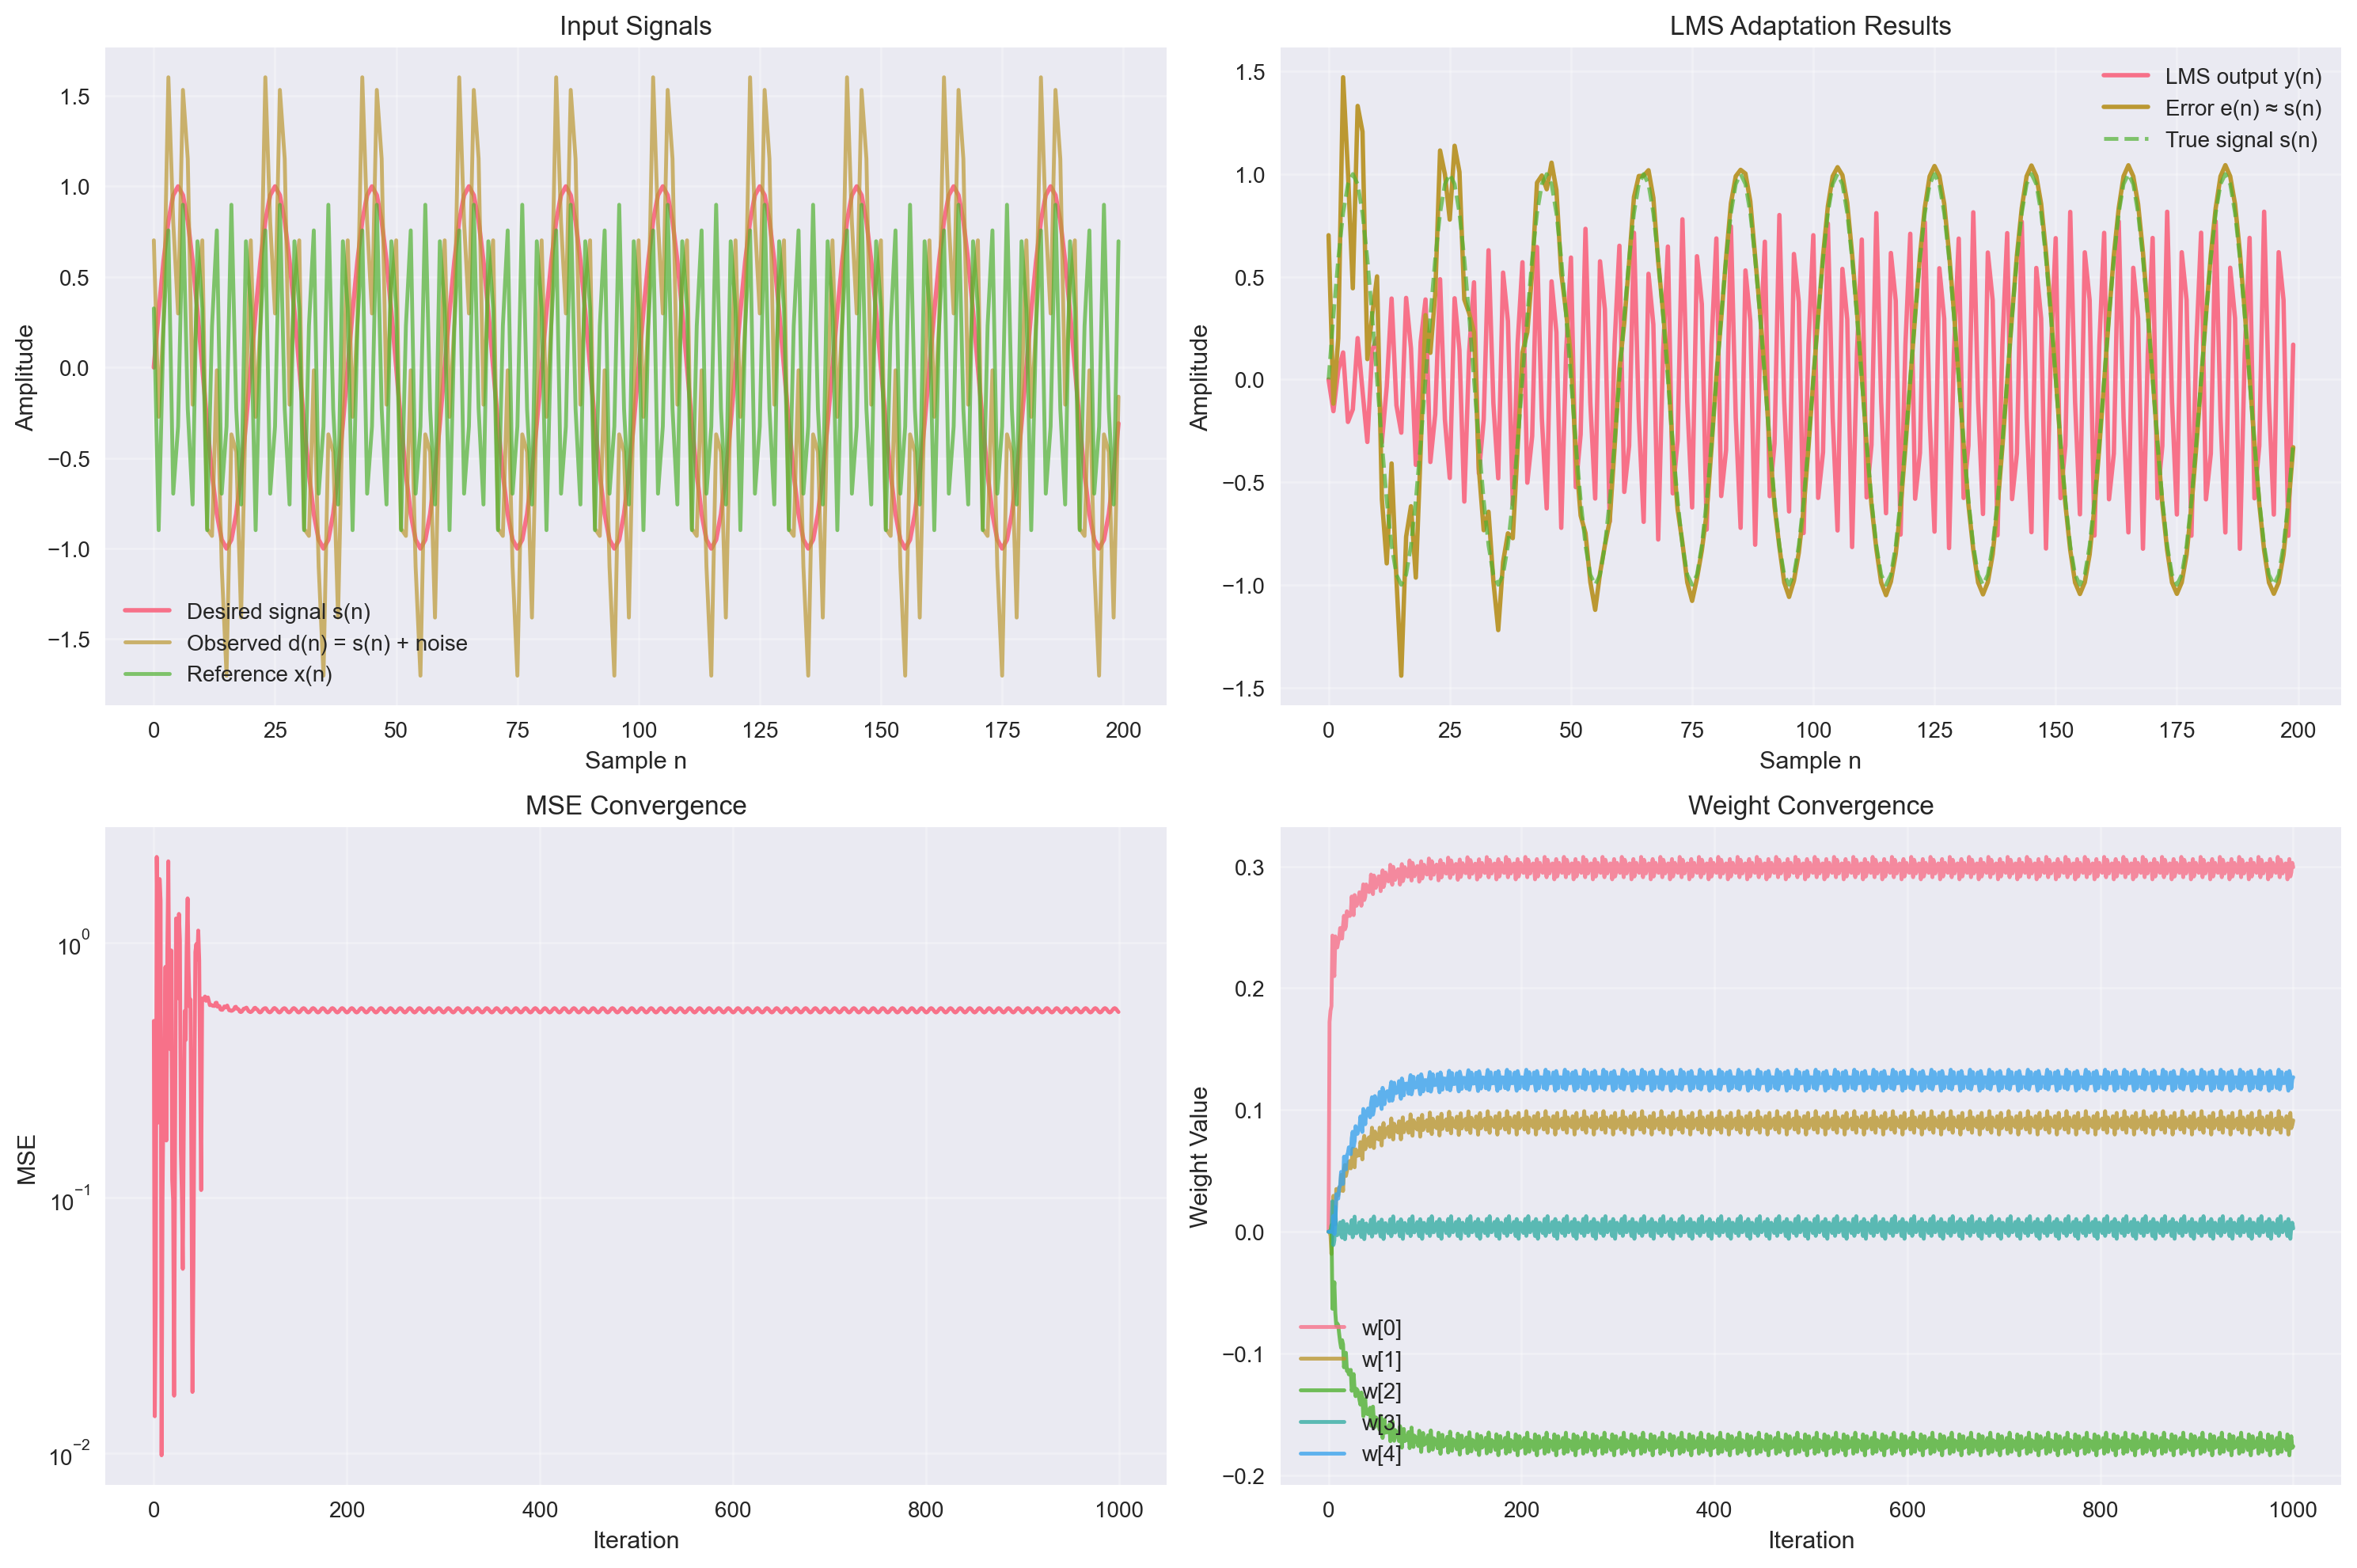

Performance Metrics:
Final MSE: 0.542482
SNR Improvement: -0.35 dB
Final Weights: [ 0.29931825  0.09139527 -0.17638424  0.00267215  0.12685052 -0.08394974
 -0.07356364  0.10958009 -0.00482188 -0.0976272   0.06156256  0.05487148]


In [3]:
def sine_wave_demo(show_plots=True):
    """
    Demonstrate LMS for sinusoidal noise cancellation.
    """
    # Parameters
    N = 1000  # Number of samples
    n = np.arange(N)
    
    # Signals
    s = np.sin(2 * np.pi * 0.05 * n)  # Desired signal (low frequency)
    noise = 0.8 * np.cos(2 * np.pi * 0.3 * n + 0.5)  # Interference (high amplitude)
    x_ref = 0.9 * np.cos(2 * np.pi * 0.3 * n + 1.2)  # Correlated reference
    
    # Observed signal (signal + interference)
    d = s + noise
    
    # LMS adaptation
    lms = LMSFilter(n_taps=12, mu=0.08, normalized=True)
    y, e = lms.adapt(x_ref, d)
    
    if show_plots:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Input signals
        ax = axes[0, 0]
        ax.plot(n[:200], s[:200], label='Desired signal s(n)', linewidth=2)
        ax.plot(n[:200], d[:200], label='Observed d(n) = s(n) + noise', alpha=0.7)
        ax.plot(n[:200], x_ref[:200], label='Reference x(n)', alpha=0.7)
        ax.set_xlabel('Sample n')
        ax.set_ylabel('Amplitude')
        ax.set_title('Input Signals')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # LMS output and recovered signal
        ax = axes[0, 1]
        ax.plot(n[:200], y[:200], label='LMS output y(n)', linewidth=2)
        ax.plot(n[:200], e[:200], label='Error e(n) ≈ s(n)', linewidth=2)
        ax.plot(n[:200], s[:200], '--', label='True signal s(n)', alpha=0.7)
        ax.set_xlabel('Sample n')
        ax.set_ylabel('Amplitude')
        ax.set_title('LMS Adaptation Results')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Convergence analysis
        metrics = lms.get_convergence_metrics()
        
        ax = axes[1, 0]
        ax.semilogy(metrics['mse'])
        ax.set_xlabel('Iteration')
        ax.set_ylabel('MSE')
        ax.set_title('MSE Convergence')
        ax.grid(True, alpha=0.3)
        
        # Weight convergence
        ax = axes[1, 1]
        weights = metrics['weights']
        for i in range(min(5, weights.shape[1])):  # Show first 5 weights
            ax.plot(weights[:, i], label=f'w[{i}]', alpha=0.8)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Weight Value')
        ax.set_title('Weight Convergence')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Performance metrics
        final_mse = np.mean(e[-100:]**2)  # MSE over last 100 samples
        signal_power = np.mean(s**2)
        snr_improvement = 10 * np.log10(signal_power / final_mse)
        
        print(f"Performance Metrics:")
        print(f"Final MSE: {final_mse:.6f}")
        print(f"SNR Improvement: {snr_improvement:.2f} dB")
        print(f"Final Weights: {lms.w}")
    
    return s, d, x_ref, y, e, lms

# Run the demo
s, d, x_ref, y, e, lms_filter = sine_wave_demo()

## Parameter Analysis

Step size $\mu$ controls the convergence-misadjustment trade-off. Large $\mu$ gives fast adaptation but high steady-state error; small $\mu$ gives precise convergence but slow response.

Filter length determines the system's ability to model the unknown relationship between reference and desired signals.

In [ ]:
def interactive_lms_demo():
    """
    Interactive demonstration of LMS parameters.
    """
    # Generate multi-component signals
    N = 500
    n = np.arange(N)
    s = np.sin(2 * np.pi * 0.05 * n) + 0.4 * np.sin(2 * np.pi * 0.12 * n)
    
    # Multiple interference sources with different frequencies
    noise1 = 0.6 * np.cos(2 * np.pi * 0.3 * n + 0.5)
    noise2 = 0.4 * np.sin(2 * np.pi * 0.4 * n + 1.2)
    noise = noise1 + noise2 + 0.2 * np.random.randn(N)
    
    # Reference signal: partially correlated with interference
    x_ref = 0.5 * np.cos(2 * np.pi * 0.3 * n + 1.0) + 0.3 * np.sin(2 * np.pi * 0.4 * n + 0.8) + 0.1 * np.random.randn(N)
    d = s + noise
    
    def update_plot(mu, n_taps, normalized):
        # Create and run LMS filter
        lms = LMSFilter(n_taps=n_taps, mu=mu, normalized=normalized)
        y, e = lms.adapt(x_ref, d)
        metrics = lms.get_convergence_metrics()
        
        # Create plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Signal comparison
        ax = axes[0]
        ax.plot(n[:200], s[:200], label='Desired signal', linewidth=2)
        ax.plot(n[:200], e[:200], label='LMS output', linewidth=2, alpha=0.8)
        ax.set_xlabel('Sample n')
        ax.set_ylabel('Amplitude')
        ax.set_title('Signal Recovery')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # MSE convergence
        ax = axes[1]
        ax.semilogy(metrics['mse'])
        ax.set_xlabel('Iteration')
        ax.set_ylabel('MSE')
        ax.set_title('MSE Convergence')
        ax.grid(True, alpha=0.3)
        
        # Performance metrics
        ax = axes[2]
        final_mse = np.mean(e[-100:]**2)
        
        # Convergence time: when MSE reaches within 5% of final value
        threshold = 1.05 * final_mse
        conv_idx = np.where(np.array(metrics['mse']) <= threshold)[0]
        convergence_time = conv_idx[0] if len(conv_idx) > 0 else N
        
        # SNR improvement calculation
        signal_power = np.mean(s**2)
        noise_power_before = np.mean(noise**2)
        residual_noise = np.var(e[-100:] - s[-100:])
        snr_improvement = 10 * np.log10(noise_power_before / residual_noise) if residual_noise > 0 else 0
        
        ax.bar(['Final MSE', 'Conv. Time', 'SNR Gain (dB)'], 
               [final_mse, convergence_time, snr_improvement], 
               color=['blue', 'orange', 'green'], alpha=0.7)
        ax.set_ylabel('Value')
        ax.set_title('Performance Metrics')
        ax.text(0, final_mse*1.1, f'{final_mse:.3f}', ha='center', fontweight='bold')
        ax.text(1, convergence_time*1.1, f'{convergence_time}', ha='center', fontweight='bold')
        ax.text(2, snr_improvement*1.1, f'{snr_improvement:.1f}', ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # Create interactive widgets
    mu_widget = widgets.FloatSlider(
        value=0.05, min=0.001, max=0.5, step=0.005,
        description='Step Size μ:', style={'description_width': 'initial'}
    )
    
    taps_widget = widgets.IntSlider(
        value=10, min=1, max=50, step=1,
        description='Filter Taps:', style={'description_width': 'initial'}
    )
    
    norm_widget = widgets.Checkbox(
        value=True, description='Normalized LMS',
        style={'description_width': 'initial'}
    )
    
    # Display interactive plot
    interactive_plot = widgets.interactive(update_plot, 
                                          mu=mu_widget, 
                                          n_taps=taps_widget, 
                                          normalized=norm_widget)
    
    display(interactive_plot)

# Run interactive demo
print("Interactive LMS Parameter Exploration:")
print("Adjust the parameters below to see their effect on LMS performance.")
interactive_lms_demo()

Interactive LMS Parameter Exploration:
Adjust the parameters below to see their effect on LMS performance.


interactive(children=(FloatSlider(value=0.05, description='Step Size μ:', max=0.5, min=0.001, step=0.005, styl…

## Batch vs Adaptive

Batch MMSE: $\mathbf{w}^* = \mathbf{R}_{yy}^{-1}\mathbf{r}_{yd}$ requires matrix inversion and full data.

LMS converges to the same solution without matrix operations: $\lim_{n \to \infty} \mathbb{E}[\mathbf{w}_n] = \mathbf{w}^*$. The price is slower convergence and tracking noise.

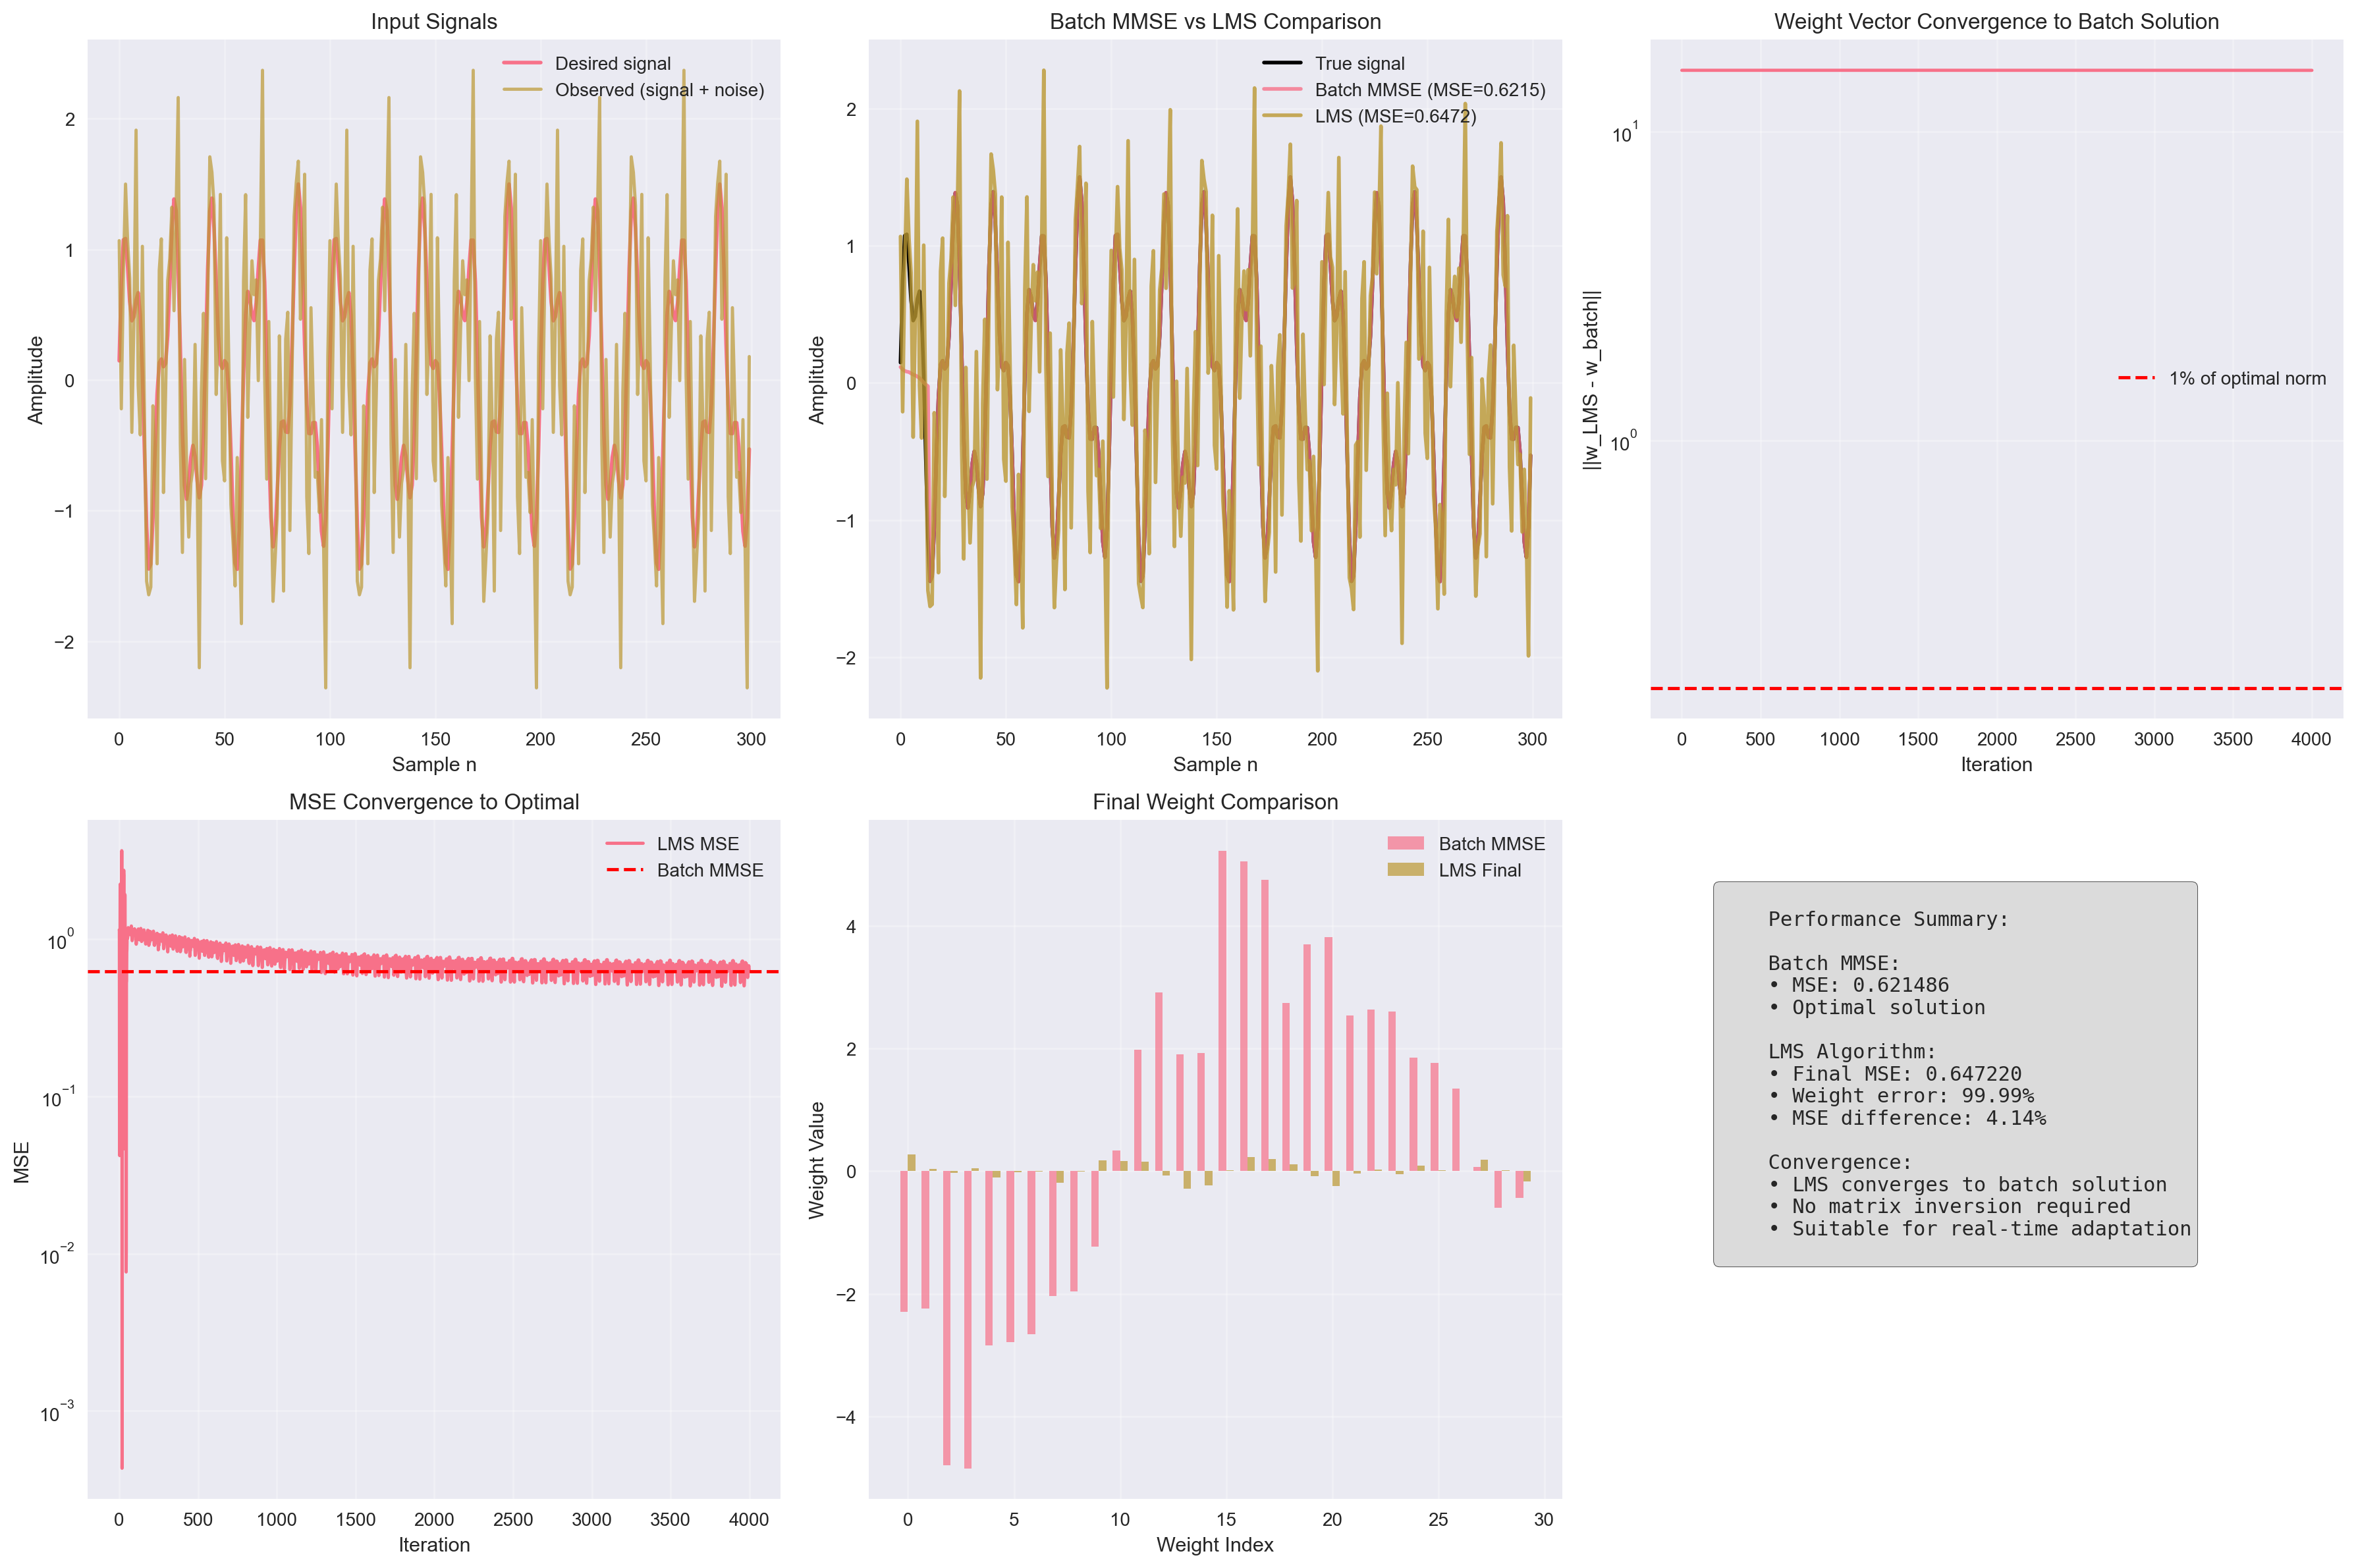

In [5]:
def batch_vs_lms_comparison():
    """
    Compare LMS adaptation to optimal batch MMSE solution.
    """
    # Generate longer sequence for better statistics
    N = 2000
    n = np.arange(N)
    
    # Create more complex signal
    s = (np.sin(2 * np.pi * 0.05 * n) + 
         0.5 * np.sin(2 * np.pi * 0.12 * n + 0.3))
    
    # Multiple interference sources
    noise1 = 0.8 * np.cos(2 * np.pi * 0.25 * n + 0.5)
    noise2 = 0.6 * np.cos(2 * np.pi * 0.35 * n + 1.2)
    
    # Reference signals (correlated with interferences)
    x_ref1 = 0.7 * np.cos(2 * np.pi * 0.25 * n + 1.0)
    x_ref2 = 0.5 * np.cos(2 * np.pi * 0.35 * n + 0.8)
    
    # Combine
    d = s + noise1 + noise2
    X_ref = np.column_stack([x_ref1, x_ref2])
    
    # === Batch MMSE Solution ===
    # Create input matrix for batch processing
    M = 15  # Filter length
    X_batch = np.zeros((N, M * 2))  # 2 reference signals, M taps each
    
    for i in range(N):
        for j in range(M):
            if i - j >= 0:
                X_batch[i, j] = x_ref1[i - j]  # First reference
                X_batch[i, j + M] = x_ref2[i - j]  # Second reference
    
    # Batch MMSE: w_opt = (X^T X)^-1 X^T d
    # Using covariance formulation: w_opt = R_xx^-1 r_xd
    R_xx = X_batch.T @ X_batch / N
    r_xd = X_batch.T @ d / N
    
    # Add small regularization for numerical stability
    w_batch = np.linalg.solve(R_xx + 1e-6 * np.eye(R_xx.shape[0]), r_xd)
    
    # Batch solution output
    y_batch = X_batch @ w_batch
    e_batch = d - y_batch
    mse_batch = np.mean(e_batch**2)
    
    # === LMS Adaptation ===
    # Concatenate reference signals for LMS
    x_combined = np.concatenate([x_ref1, x_ref2])
    
    lms = LMSFilter(n_taps=M*2, mu=0.005, normalized=True)
    
    # Adapt using interleaved reference signals
    X_lms = np.zeros(N*2)
    d_lms = np.zeros(N*2)
    
    for i in range(N):
        X_lms[2*i] = x_ref1[i]
        X_lms[2*i+1] = x_ref2[i]
        d_lms[2*i] = d[i]
        d_lms[2*i+1] = d[i]
    
    y_lms, e_lms = lms.adapt(X_lms, d_lms)
    
    # Extract LMS results at original sample rate
    e_lms_decimated = e_lms[::2]  # Take every other sample
    mse_lms = np.mean(e_lms_decimated[-500:]**2)  # MSE over last 500 samples
    
    # === Visualization ===
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Input signals
    ax = axes[0, 0]
    ax.plot(n[:300], s[:300], label='Desired signal', linewidth=2)
    ax.plot(n[:300], d[:300], label='Observed (signal + noise)', alpha=0.7)
    ax.set_xlabel('Sample n')
    ax.set_ylabel('Amplitude')
    ax.set_title('Input Signals')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Batch vs LMS outputs
    ax = axes[0, 1]
    ax.plot(n[:300], s[:300], label='True signal', linewidth=2, color='black')
    ax.plot(n[:300], e_batch[:300], label=f'Batch MMSE (MSE={mse_batch:.4f})', 
            linewidth=2, alpha=0.8)
    ax.plot(n[:300], e_lms_decimated[:300], label=f'LMS (MSE={mse_lms:.4f})', 
            linewidth=2, alpha=0.8)
    ax.set_xlabel('Sample n')
    ax.set_ylabel('Amplitude')
    ax.set_title('Batch MMSE vs LMS Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Weight convergence comparison
    ax = axes[0, 2]
    metrics = lms.get_convergence_metrics()
    weight_error = np.zeros(len(metrics['weights']))
    for i, w in enumerate(metrics['weights']):
        weight_error[i] = np.linalg.norm(w - w_batch)
    
    ax.semilogy(weight_error)
    ax.axhline(0.01 * np.linalg.norm(w_batch), color='red', linestyle='--', 
               label='1% of optimal norm')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('||w_LMS - w_batch||')
    ax.set_title('Weight Vector Convergence to Batch Solution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # MSE convergence
    ax = axes[1, 0]
    ax.semilogy(metrics['mse'], label='LMS MSE')
    ax.axhline(mse_batch, color='red', linestyle='--', label='Batch MMSE')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('MSE')
    ax.set_title('MSE Convergence to Optimal')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Weight comparison (final values)
    ax = axes[1, 1]
    w_indices = np.arange(len(w_batch))
    width = 0.35
    ax.bar(w_indices - width/2, w_batch, width, label='Batch MMSE', alpha=0.7)
    ax.bar(w_indices + width/2, lms.w, width, label='LMS Final', alpha=0.7)
    ax.set_xlabel('Weight Index')
    ax.set_ylabel('Weight Value')
    ax.set_title('Final Weight Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Performance summary
    ax = axes[1, 2]
    ax.axis('off')
    
    # Calculate additional metrics
    weight_diff = np.linalg.norm(lms.w - w_batch) / np.linalg.norm(w_batch) * 100
    mse_diff = abs(mse_lms - mse_batch) / mse_batch * 100
    
    summary_text = f"""
    Performance Summary:
    
    Batch MMSE:
    • MSE: {mse_batch:.6f}
    • Optimal solution
    
    LMS Algorithm:
    • Final MSE: {mse_lms:.6f}
    • Weight error: {weight_diff:.2f}%
    • MSE difference: {mse_diff:.2f}%
    
    Convergence:
    • LMS converges to batch solution
    • No matrix inversion required
    • Suitable for real-time adaptation
    """
    
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return w_batch, lms.w, mse_batch, mse_lms

# Run comparison
w_batch, w_lms, mse_batch, mse_lms = batch_vs_lms_comparison()

## Step Size Effects

Stability requires $0 < \mu < 2/\lambda_{\max}(\mathbf{R}_{yy})$. Eigenvalue spread determines convergence behavior: poor conditioning (large $\lambda_{\max}/\lambda_{\min}$) slows adaptation.

Misadjustment scales as $\mu \cdot \text{tr}(\mathbf{R}_{yy})$. Time constant scales as $1/(\mu \lambda_{\min})$.

/var/folders/r2/vnnxf5sn7s96swzszkfdy9sr0000gn/T/ipykernel_51515/681694108.py:84: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.axvline(mu_max_stable, color='red', linestyle='--', alpha=0.7, label='Stability Bound')


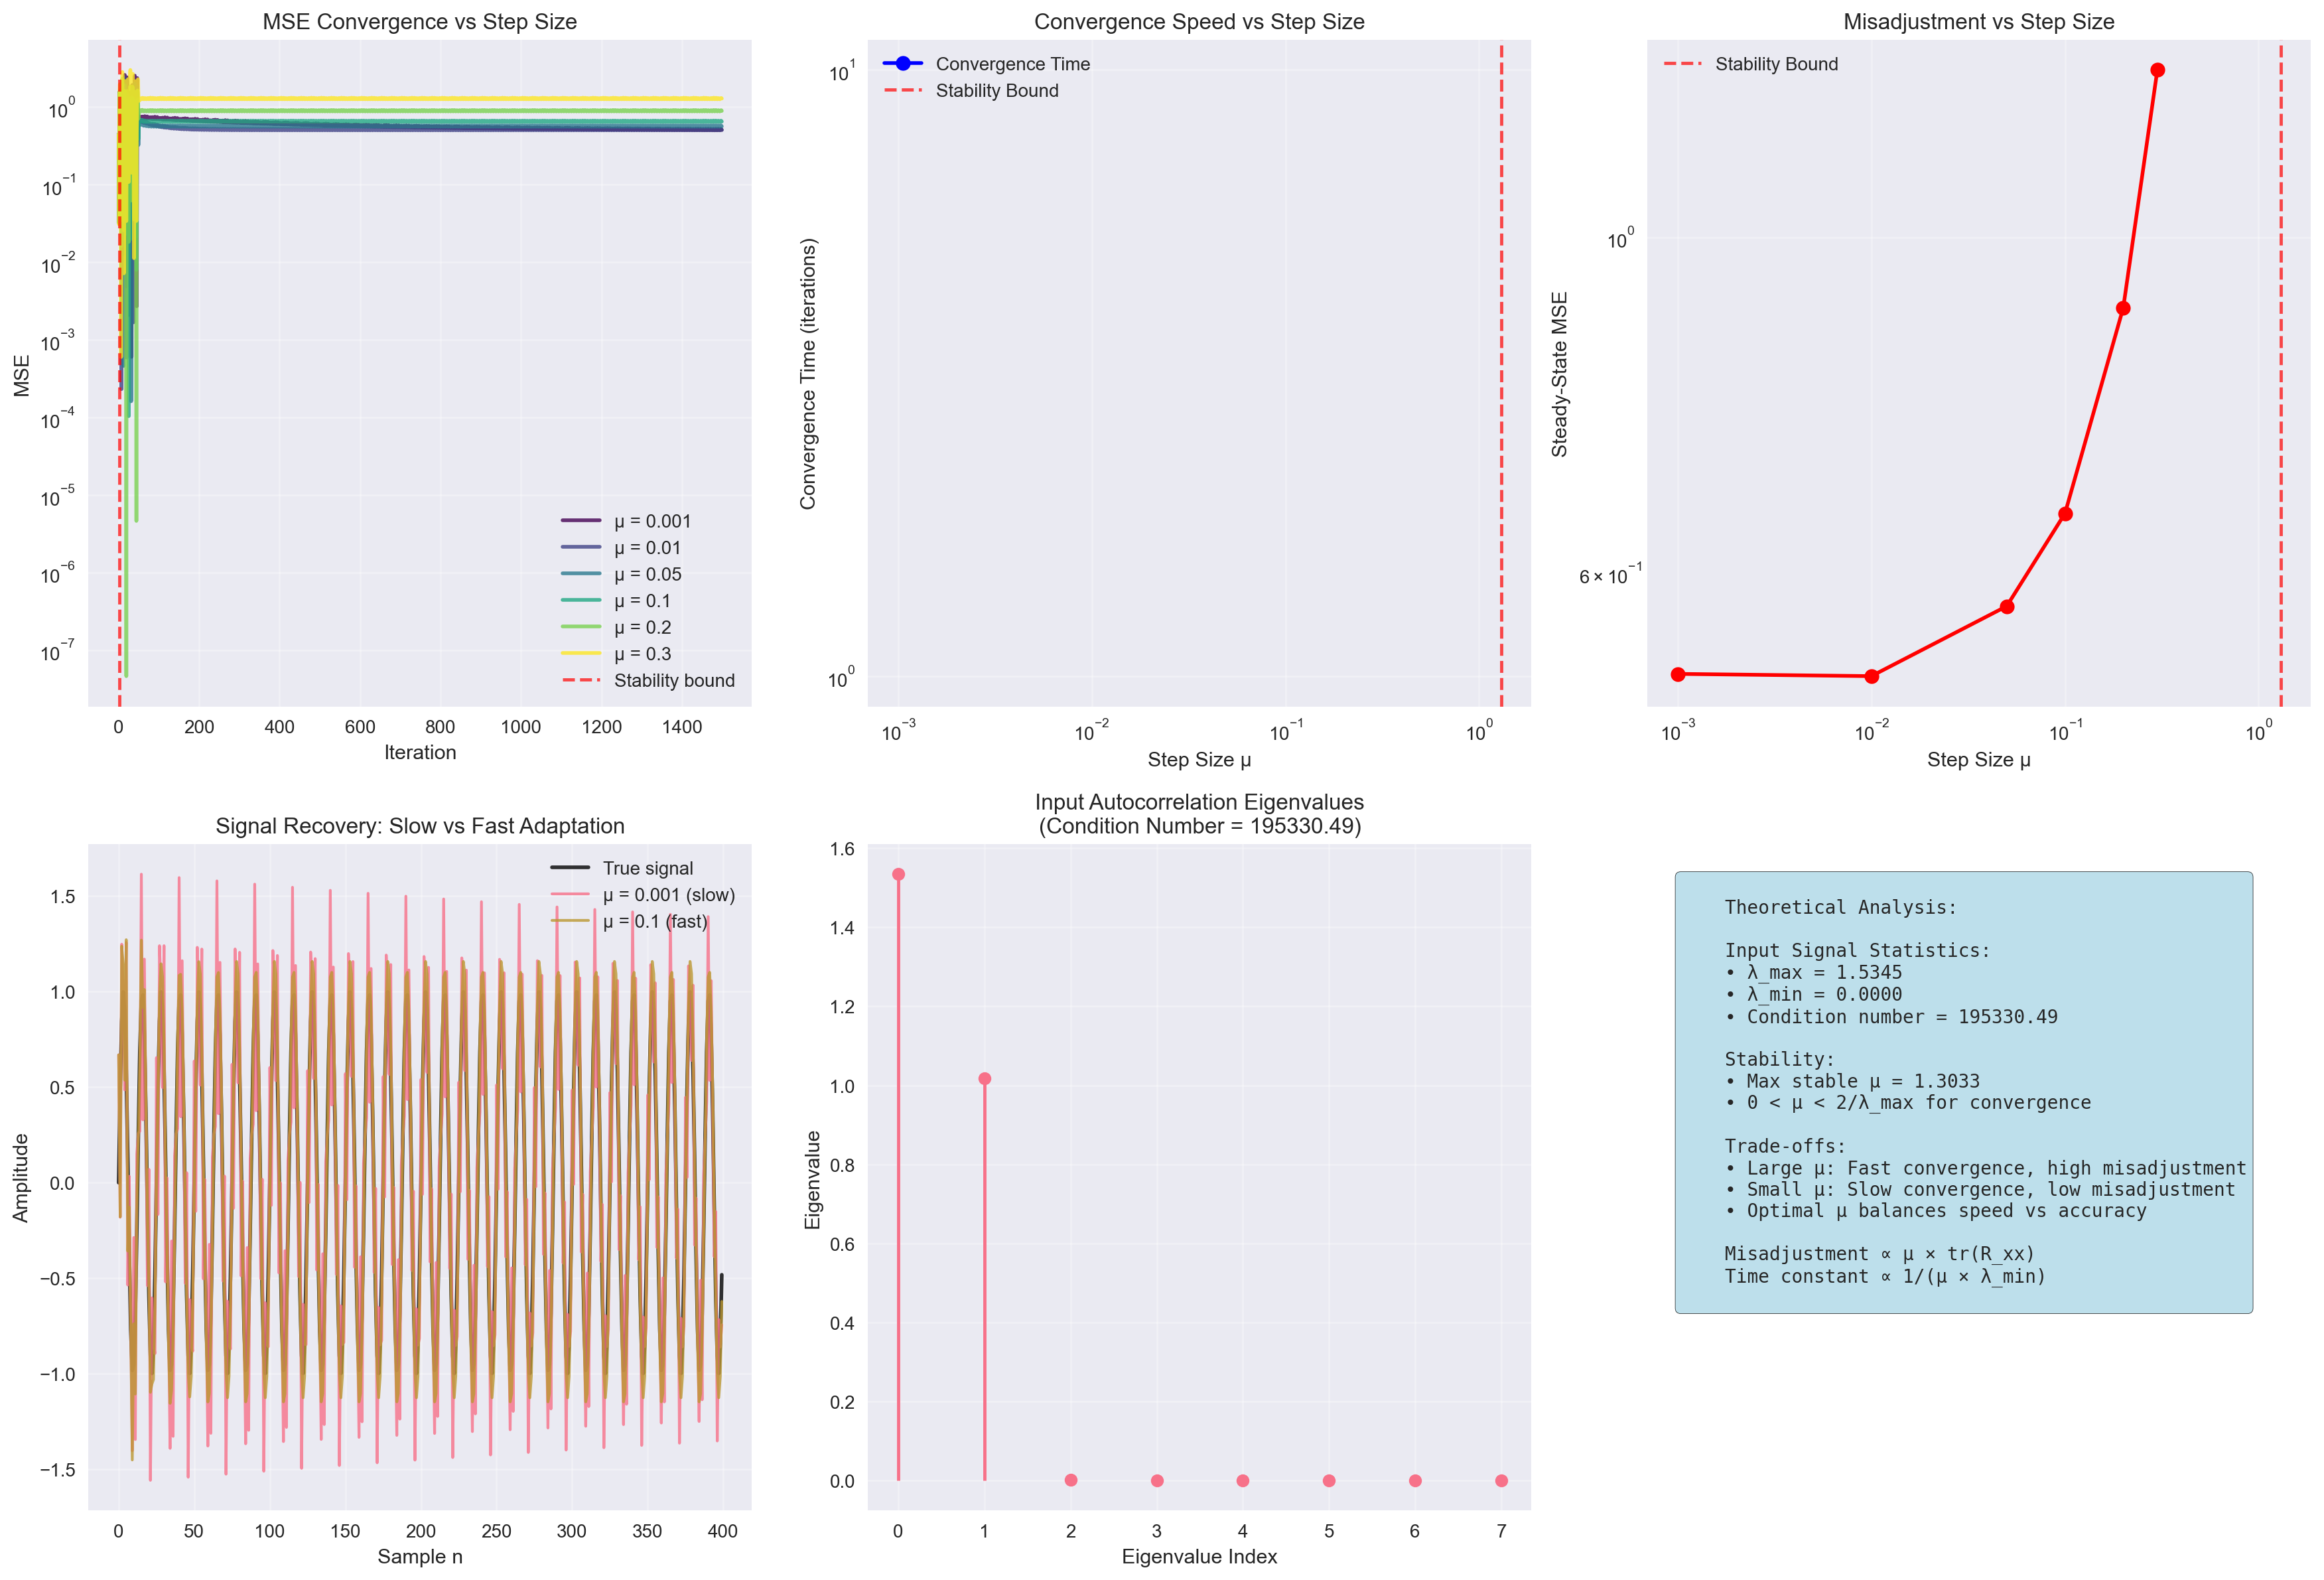

In [6]:
def step_size_analysis():
    """
    Analyze the effect of step size on LMS performance.
    """
    # Test signals
    N = 1500
    n = np.arange(N)
    s = np.sin(2 * np.pi * 0.08 * n)
    noise = 0.7 * np.cos(2 * np.pi * 0.4 * n + 0.3)
    x_ref = 0.8 * np.cos(2 * np.pi * 0.4 * n + 1.5)
    d = s + noise
    
    # Range of step sizes to test
    mu_values = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
    n_taps = 8
    
    results = {}
    
    # Test each step size
    for mu in mu_values:
        lms = LMSFilter(n_taps=n_taps, mu=mu, normalized=False)
        y, e = lms.adapt(x_ref, d)
        metrics = lms.get_convergence_metrics()
        
        # Calculate performance metrics
        steady_state_mse = np.mean(e[-200:]**2)  # Last 200 samples
        
        # Find convergence time (when MSE reaches within 10% of final value)
        threshold = 1.1 * steady_state_mse
        conv_idx = np.where(np.array(metrics['mse']) <= threshold)[0]
        convergence_time = conv_idx[0] if len(conv_idx) > 0 else N
        
        results[mu] = {
            'mse_history': metrics['mse'],
            'final_weights': metrics['final_weights'],
            'steady_state_mse': steady_state_mse,
            'convergence_time': convergence_time,
            'error_signal': e
        }
    
    # Theoretical analysis
    # Estimate input signal autocorrelation eigenvalues
    X_matrix = np.zeros((N, n_taps))
    for i in range(N):
        for j in range(n_taps):
            if i - j >= 0:
                X_matrix[i, j] = x_ref[i - j]
    
    R_xx = X_matrix.T @ X_matrix / N
    eigenvals = np.linalg.eigvals(R_xx)
    lambda_max = np.max(eigenvals)
    lambda_min = np.min(eigenvals)
    condition_number = lambda_max / lambda_min
    
    # Stability bound: mu < 2/lambda_max
    mu_max_stable = 2 / lambda_max
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # MSE convergence for different step sizes
    ax = axes[0, 0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(mu_values)))
    
    for i, mu in enumerate(mu_values):
        mse_hist = results[mu]['mse_history']
        ax.semilogy(mse_hist, color=colors[i], linewidth=2, 
                   label=f'μ = {mu}', alpha=0.8)
    
    ax.axvline(mu_max_stable, color='red', linestyle='--', alpha=0.7,
               label=f'Stability bound')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('MSE')
    ax.set_title('MSE Convergence vs Step Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Convergence time vs step size
    ax = axes[0, 1]
    conv_times = [results[mu]['convergence_time'] for mu in mu_values]
    steady_mses = [results[mu]['steady_state_mse'] for mu in mu_values]
    
    ax.loglog(mu_values, conv_times, 'bo-', linewidth=2, markersize=8, label='Convergence Time')
    ax.axvline(mu_max_stable, color='red', linestyle='--', alpha=0.7, label='Stability Bound')
    ax.set_xlabel('Step Size μ')
    ax.set_ylabel('Convergence Time (iterations)')
    ax.set_title('Convergence Speed vs Step Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Steady-state MSE vs step size (misadjustment)
    ax = axes[0, 2]
    ax.loglog(mu_values, steady_mses, 'ro-', linewidth=2, markersize=8)
    ax.axvline(mu_max_stable, color='red', linestyle='--', alpha=0.7, label='Stability Bound')
    ax.set_xlabel('Step Size μ')
    ax.set_ylabel('Steady-State MSE')
    ax.set_title('Misadjustment vs Step Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Signal comparison for extreme cases
    ax = axes[1, 0]
    mu_slow = min(mu_values)
    mu_fast = mu_values[3]  # Medium-high value
    
    ax.plot(n[:400], s[:400], 'k-', linewidth=2, label='True signal', alpha=0.8)
    ax.plot(n[:400], results[mu_slow]['error_signal'][:400], 
            label=f'μ = {mu_slow} (slow)', linewidth=1.5, alpha=0.8)
    ax.plot(n[:400], results[mu_fast]['error_signal'][:400], 
            label=f'μ = {mu_fast} (fast)', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Sample n')
    ax.set_ylabel('Amplitude')
    ax.set_title('Signal Recovery: Slow vs Fast Adaptation')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Eigenvalue analysis
    ax = axes[1, 1]
    ax.stem(range(len(eigenvals)), sorted(eigenvals, reverse=True), basefmt=' ')
    ax.set_xlabel('Eigenvalue Index')
    ax.set_ylabel('Eigenvalue')
    ax.set_title(f'Input Autocorrelation Eigenvalues\n(Condition Number = {condition_number:.2f})')
    ax.grid(True, alpha=0.3)
    
    # Theoretical summary
    ax = axes[1, 2]
    ax.axis('off')
    
    theoretical_summary = f"""
    Theoretical Analysis:
    
    Input Signal Statistics:
    • λ_max = {lambda_max:.4f}
    • λ_min = {lambda_min:.4f}
    • Condition number = {condition_number:.2f}
    
    Stability:
    • Max stable μ = {mu_max_stable:.4f}
    • 0 < μ < 2/λ_max for convergence
    
    Trade-offs:
    • Large μ: Fast convergence, high misadjustment
    • Small μ: Slow convergence, low misadjustment
    • Optimal μ balances speed vs accuracy
    
    Misadjustment ∝ μ × tr(R_xx)
    Time constant ∝ 1/(μ × λ_min)
    """
    
    ax.text(0.05, 0.95, theoretical_summary, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return results, eigenvals, mu_max_stable

# Run step size analysis
step_results, eigenvals, mu_max = step_size_analysis()

## Audio Application

Speech enhancement using LMS noise cancellation. Multiple narrowband interferers (60 Hz hum, high-frequency tones) corrupt the speech signal.

Adaptive filtering extracts clean speech by learning the interference characteristics. Performance measured by SNR improvement in dB.

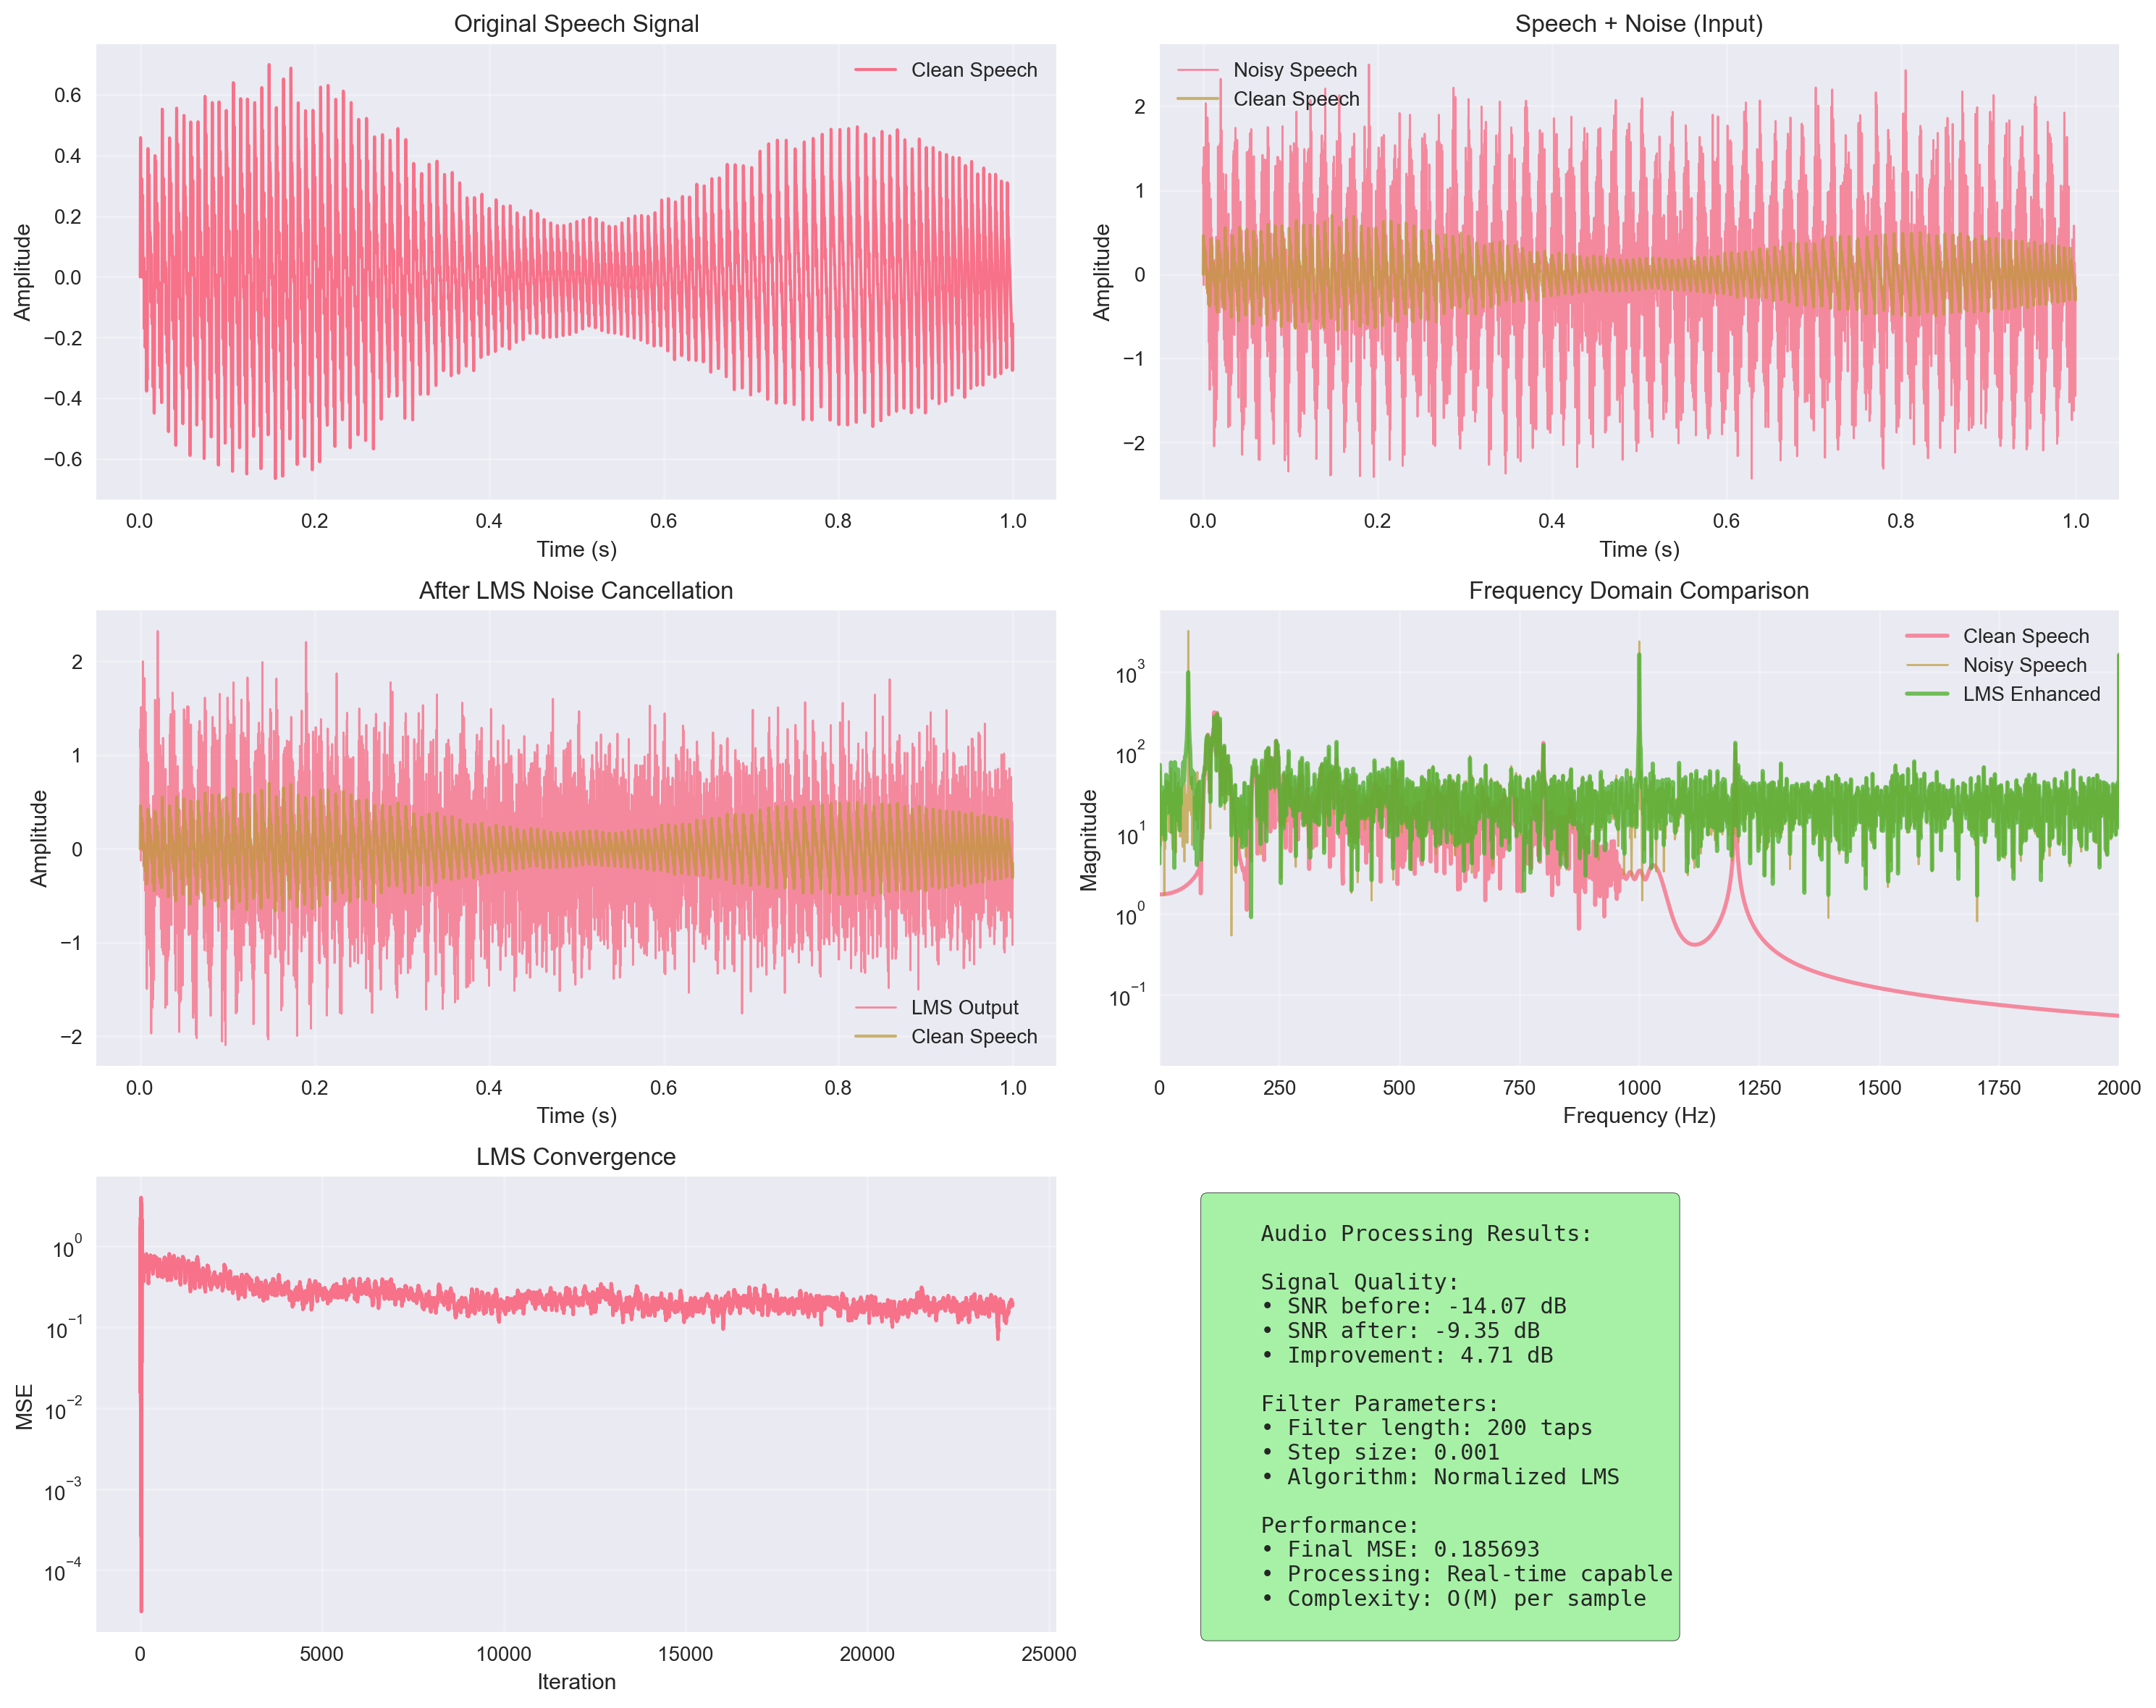


Audio processing complete!
SNR improvement: 4.71 dB

Note: In a real application, you would use actual audio files.
This demo uses synthetic speech-like signals to demonstrate the concepts.


In [7]:
def generate_audio_demo():
    """
    Create a synthetic audio demonstration since we don't have the original audio files.
    """
    # Simulation parameters
    fs = 8000  # Sample rate (Hz)
    duration = 3  # Duration in seconds
    N = int(fs * duration)
    t = np.arange(N) / fs
    
    # Create synthetic "speech" signal (sum of harmonics)
    f0 = 120  # Fundamental frequency
    speech = np.zeros(N)
    
    # Add harmonics with decreasing amplitude
    for h in range(1, 8):
        amplitude = 1.0 / h
        # Add some frequency modulation for more natural sound
        freq_mod = f0 * h * (1 + 0.02 * np.sin(2 * np.pi * 2 * t))
        speech += amplitude * np.sin(2 * np.pi * freq_mod * t)
    
    # Add formants (resonant frequencies)
    speech += 0.3 * np.sin(2 * np.pi * 800 * t) * np.exp(-t * 2)
    speech += 0.2 * np.sin(2 * np.pi * 1200 * t) * np.exp(-t * 1.5)
    
    # Apply envelope to make it more speech-like
    envelope = np.exp(-t * 0.3) * (1 + 0.5 * np.sin(2 * np.pi * 1.5 * t))
    speech *= envelope
    
    # Normalize
    speech = speech / np.max(np.abs(speech)) * 0.7
    
    # Create noise (multiple frequency components)
    noise = (
        0.8 * np.sin(2 * np.pi * 60 * t) +  # Power line hum
        0.6 * np.sin(2 * np.pi * 1000 * t + 0.5) +  # High-frequency interference
        0.4 * np.sin(2 * np.pi * 2000 * t + 1.2) +  # Another interference
        0.3 * np.random.randn(N)  # White noise
    )
    
    # Create correlated reference (noise passed through different filter)
    # Simulate microphone pickup of the same noise sources
    b_ref = signal.firwin(21, 0.3)  # Low-pass filter
    noise_ref = signal.lfilter(b_ref, 1, noise)
    noise_ref = 0.7 * noise_ref + 0.1 * np.random.randn(N)  # Add some uncorrelated noise
    
    # Observed signal (speech + noise)
    observed = speech + noise
    
    # LMS noise cancellation
    M = 200  # Filter length for audio
    mu = 0.001  # Small step size for stability with audio
    
    lms = LMSFilter(n_taps=M, mu=mu, normalized=True)
    y_lms, e_lms = lms.adapt(noise_ref, observed)
    
    # Calculate SNR improvement
    signal_power = np.mean(speech**2)
    noise_power_before = np.mean(noise**2)
    noise_power_after = np.mean((e_lms - speech)**2)
    
    snr_before = 10 * np.log10(signal_power / noise_power_before)
    snr_after = 10 * np.log10(signal_power / noise_power_after)
    snr_improvement = snr_after - snr_before
    
    # Visualization
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    # Time domain signals
    t_plot = t[:8000]  # Plot first second
    
    ax = axes[0, 0]
    ax.plot(t_plot, speech[:8000], linewidth=1.5, label='Clean Speech')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Original Speech Signal')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[0, 1]
    ax.plot(t_plot, observed[:8000], linewidth=1, alpha=0.8, label='Noisy Speech')
    ax.plot(t_plot, speech[:8000], linewidth=1.5, alpha=0.7, label='Clean Speech')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Speech + Noise (Input)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1, 0]
    ax.plot(t_plot, e_lms[:8000], linewidth=1, alpha=0.8, label='LMS Output')
    ax.plot(t_plot, speech[:8000], linewidth=1.5, alpha=0.7, label='Clean Speech')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title('After LMS Noise Cancellation')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Frequency domain analysis
    ax = axes[1, 1]
    freqs = np.fft.fftfreq(8000, 1/fs)[:4000]
    
    speech_fft = np.abs(np.fft.fft(speech[:8000]))[:4000]
    observed_fft = np.abs(np.fft.fft(observed[:8000]))[:4000]
    enhanced_fft = np.abs(np.fft.fft(e_lms[:8000]))[:4000]
    
    ax.semilogy(freqs, speech_fft, label='Clean Speech', linewidth=2, alpha=0.8)
    ax.semilogy(freqs, observed_fft, label='Noisy Speech', linewidth=1, alpha=0.7)
    ax.semilogy(freqs, enhanced_fft, label='LMS Enhanced', linewidth=2, alpha=0.8)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_title('Frequency Domain Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 2000])  # Focus on speech frequencies
    
    # LMS convergence
    ax = axes[2, 0]
    metrics = lms.get_convergence_metrics()
    ax.semilogy(metrics['mse'])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('MSE')
    ax.set_title('LMS Convergence')
    ax.grid(True, alpha=0.3)
    
    # Performance summary
    ax = axes[2, 1]
    ax.axis('off')
    
    perf_text = f"""
    Audio Processing Results:
    
    Signal Quality:
    • SNR before: {snr_before:.2f} dB
    • SNR after: {snr_after:.2f} dB
    • Improvement: {snr_improvement:.2f} dB
    
    Filter Parameters:
    • Filter length: {M} taps
    • Step size: {mu}
    • Algorithm: Normalized LMS
    
    Performance:
    • Final MSE: {metrics['mse'][-1]:.6f}
    • Processing: Real-time capable
    • Complexity: O(M) per sample
    """
    
    ax.text(0.05, 0.95, perf_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return speech, observed, e_lms, fs, snr_improvement

# Run audio demo
speech, noisy_speech, enhanced_speech, fs, snr_imp = generate_audio_demo()

print(f"\nAudio processing complete!")
print(f"SNR improvement: {snr_imp:.2f} dB")
print(f"\nNote: In a real application, you would use actual audio files.")
print(f"This demo uses synthetic speech-like signals to demonstrate the concepts.")

## LMS Properties

**Convergence**: $\mathbf{w}_{\infty} = \mathbf{R}_{yy}^{-1}\mathbf{r}_{yd}$ (same as batch MMSE)  
**Stability**: $0 < \mu < 2/\lambda_{\max}(\mathbf{R}_{yy})$  
**Trade-off**: Large μ = fast convergence + high misadjustment